In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
import starfit
from pathlib import Path

from starfit.utils import find_data
from starfit.autils.stardb import StarDB
from starfit.autils.abusets import SolAbu

In [2]:
import socket
import pandas as pd
from pathlib import Path
from astropy import constants as const
from astropy import units
coeff = (0.6 * (const.G * const.M_sun) / (12e3 * units.m * (const.c)**2)).value

hostname = socket.gethostname()
if hostname == 'jerome-linux':
    datadir = Path('/home/jerome/Documents/GitHub')
elif hostname == 'sage2020':
    datadir = Path('/home/jiangrz/hdd23')
datapath = datadir/Path('Data/rproc/heavy_element_enhanced_stars_write_err.csv')
stardir = datadir/Path('Data/rproc/star')
lightdir = datadir/Path('Data/Raw/MPs/1_Li/Stars')

In [3]:
element_list = [
    'h', 'he', 'li', 'be', 'b', 'c', 'n', 'o', 'file', 'ne', 
    'na', 'mg', 'al', 'si', 'p', 's', 'cl', 'ar', 'k', 'ca',
    'sc', 'ti', 'v', 'cr', 'mn', 'fe', 'co', 'ni', 'cu', 'zn',
    'ga', 'ge', 'as', 'se', 'br', 'kr', 'rb', 'sr', 'y', 'zr',
    'nb', 'mo', 'ru', 'rh', 'pd', 'ag', 'cd', 'in', 'sn', 'sb',
    'te', 'i', 'xe', 'cs', 'ba', 'la', 'ce', 'pr', 'nd', 'sm',
    'eu', 'gd', 'tb', 'dy', 'ho', 'er', 'tm', 'yb', 'lu', 'hf',
    'ta', 'w', 're', 'os', 'ir', 'pt', 'au', 'hg', 'tl', 'pb',
    'bi', 'th', 'u'
]
element_list = [_.capitalize() for _ in element_list]
ellist_nonO = element_list.copy()
ellist_nonO.remove('O')

In [4]:
df = pd.read_csv(datapath)
column_names = df.columns.values
sun = SolAbu('solas09.dat', silent=True)

In [5]:
for idx in range(len(df)):
    objname = df.loc[idx, 'objname'].split('.')[0]
    starpath = stardir/('%s.dat'%(objname))
    lightpath  = lightdir/('%s.dat'%(objname))
    with open(lightpath, 'r') as lightfile:
        lightlines = lightfile.read().splitlines()[7:-1]
        lightel = np.array([_.split()[0] for _ in lightlines])
        lightabu = np.array([_.split()[1] for _ in lightlines], dtype=float)
        lighterr = np.array([_.split()[2] for _ in lightlines], dtype=float)
        Feidx = np.in1d(lightel, 'Fe')
        feh = lightabu[Feidx]
        feherr = lighterr[Feidx]

    newel = []
    newabu = []
    newerr = []
    for el in ellist_nonO:
        logn_name = 'log_%s_new'%(el)
        logerr_name = 'err_%s_new'%(el)
        if logn_name in column_names:
            logeps_el = df.loc[idx, logn_name]
            logerr_el = df.loc[idx, logerr_name]
            abu = logeps_el -sun.log_eps(el) -feh
            err = np.sqrt(np.square(logerr_el)+np.square(feherr))
            if (logeps_el == 9.99) or (logerr_el == 9.99):
                continue
            else:
                newel.append(el)
                newabu.append(abu)
                newerr.append(err)
    newel = np.array(newel)
    newabu = np.array(newabu)
    newerr = np.array(newerr)
    
    el_reserve = ~np.in1d(lightel, newel)
    ellist = np.append(lightel[el_reserve], newel)
    abulist = np.append(lightabu[el_reserve], newabu)
    errlist = np.append(lighterr[el_reserve], newerr)

    with open(starpath, 'w') as file:
        file. write('10002\n')
        file.write('%s\n'%(objname))
        file.write('%s\n'%('Lin et al.'))
        comment = '%.2f  %.2f'%(tuple(df.loc[idx, ['ra', 'dec']].values))
        file.write('%s\n'%(comment))
        file.write('3\n')
        file.write('Fe\n')
        elnum = len(ellist)
        file.write('%s\n'%(elnum))
        for elidx in range(elnum):
            el_line = '%-3s  %5.2f  %5.2f'%(ellist[elidx], abulist[elidx], errlist[elidx])
            file.write('%s\n'%(el_line))
        file.write('As09')

In [16]:
database = [
    'znuc2012.S4.star.el.y.stardb.gz', 
    # 'rproc.wu.star.el.y.stardb.xz', 
    'rproc.just15.star.el.y.stardb.xz'
]
columns = []
properties = ['name', 'FeH', 'N', 'fitness']
freeparams_num = 0
columns.extend([('property', prop) for prop in properties])
for _didx, _dname in enumerate(database):
    dbpath = find_data('db', _dname)
    _db = StarDB(dbpath, silent=True)
    freeparams_num += np.sum(1-_db.fieldflags)
    fieldnames = _db.fieldnames
    columns.extend([('%d'%_didx, _) for _ in np.append(fieldnames, 'offset')])
    df_result = pd.DataFrame(columns=columns)
    df_result.columns = pd.MultiIndex.from_tuples(df_result.columns, names=['db_index','fieldname'])

default_exclude = np.array([3, 19, 24, 30, 21, 29])
non_rproc = np.arange(40, 58, 1)
z_exclude = np.append(default_exclude, non_rproc).tolist()
for idx in range(len(df)):
    objname = df.loc[idx, 'objname'].split('.')[0]
    starFeH = df.loc[idx, 'FeH']
    starname = objname
    starpath = stardir/('%s.dat'%(objname))
    multi = starfit.Multi(
        starpath, db=database, 
        z_min=3, z_max=100, z_exclude=z_exclude, 
        silent=True, sol_size=2, group=[1, 1]
    )
    starN = multi.star.element_abundances[~multi.exclude_index].shape[0]
    dof = starN - 7

    starfitn = multi.sorted_fitness[0] / dof
    starindices = multi.sorted_stars[0]['index']
    staroffsets = multi.sorted_stars[0]['offset']
    db_idx = multi.db_idx[starindices]
    db_off = multi.db_off
    starindices -= db_off
    starprop = [starname, starFeH, starN, starfitn]
    columndata = starprop
    for _db_idx, _staridx, _staroffset in zip(db_idx, starindices, staroffsets):
        starfield = list(multi.db[_db_idx].fielddata[_staridx])
        stardata = starfield + [_staroffset]
        columndata += stardata
    df_result.loc[idx] = columndata

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
/tmp/ipykernel_1293384/1353102351.py:35: RuntimeWarnin

ValueError: unexpected array size: new_size=1, got array with arr_size=0


In [11]:
df_result.to_csv('result.csv', index=False)

In [30]:
database = [
    'rproc.wu.star.el.y.stardb.xz', 
    # 'rproc.just15.star.el.y.stardb.xz'
]
columns = []
properties = ['name', 'FeH', 'N', 'fitness']
freeparams_num = 0
columns.extend([('property', prop) for prop in properties])
dbpath = find_data('db', database)
db = StarDB(dbpath, silent=True)
freeparams_num += np.sum(1-db.fieldflags)
fieldnames = db.fieldnames
columns.extend([('%d'%0, _) for _ in np.append(fieldnames, 'offset')])
df_result_s = pd.DataFrame(columns=columns)
df_result_s.columns = pd.MultiIndex.from_tuples(df_result_s.columns, names=['db_index','fieldname'])

for idx in range(len(df)):
    objname = df.loc[idx, 'objname'].split('.')[0]
    starFeH = df.loc[idx, 'FeH']
    starname = objname
    starpath = stardir/('%s.dat'%(objname))
    multi = starfit.Multi(
        starpath, db=database, 
        z_min=35, z_max=100, z_exclude=[3, 19, 24, 30, 21, 29], 
        silent=True, sol_size=1, group=1, 
        constraints='model != 33, model != 72, model != 73, model != 101, model != 111'
    )
    starN = multi.star.element_abundances[~multi.exclude_index].shape[0]
    dof = starN - 3

    starfitn = multi.sorted_fitness[0] / dof
    starindices = multi.sorted_stars[0]['index']
    staroffsets = multi.sorted_stars[0]['offset']
    db_idx = multi.db_idx[starindices]
    db_off = multi.db_off
    starindices -= db_off
    starprop = [starname, starFeH, starN, starfitn]
    columndata = starprop
    for _db_idx, _staridx, _staroffset in zip(db_idx, starindices, staroffsets):
        starfield = list(multi.db[_db_idx].fielddata[_staridx])
        stardata = starfield + [_staroffset]
        columndata += stardata
    df_result_s.loc[idx] = columndata

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

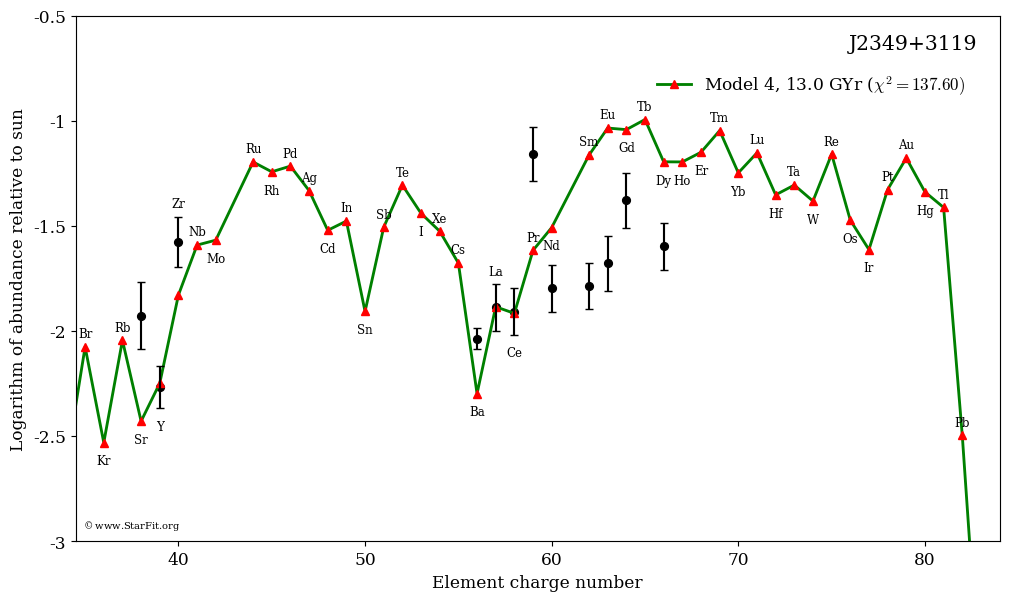

In [25]:
multi.plot(xlim=(34.5, 84), ylim=(-3, -.5))

In [31]:
df_result_s.to_csv('solresult_wu.csv', index=False)